# import 

In [2]:
import pyspark
from pyspark.sql import SparkSession
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# data pyspark

## base de données sur le diesel

In [3]:
spark = SparkSession.builder.appName("Bresil").getOrCreate()
sc = spark.sparkContext
rdd = sc.textFile(r"./data/gas_diesel.csv")


### data without header

In [6]:
table_prix_head = rdd.take(1)
table_prix_no_header = rdd.filter(lambda row: row != table_prix_head[0])
table_prix_head.take(1)

In [20]:
table_prix_head

['Date,A1,A2,A3,R1,R2,R3,M1,M2,M3,P1,P2,P3,D1']

### data preprocessing 

In [8]:
new_table_prix = table_prix_no_header.map(lambda line: tuple(line.split(',')))\
                                     .map(lambda line : tuple([datetime.strptime(line[0], "%m/%d/%Y")] + list(map(float, line[1:]))))\
                                     .filter(lambda line : line[0].year in ( 2020, 2020))

### récupération des dates et prix

In [9]:
date_date_galons = new_table_prix.map(lambda line: line[0]).collect()
prix_data_galons = new_table_prix.map(lambda line: line[1]).collect()
prix_data_galons_2 = new_table_prix.map(lambda line: line[2]).collect()

### visualisation de la données sur 2020

Text(0.5, 0.98, "Evolution du prix de l'essence en 2020")

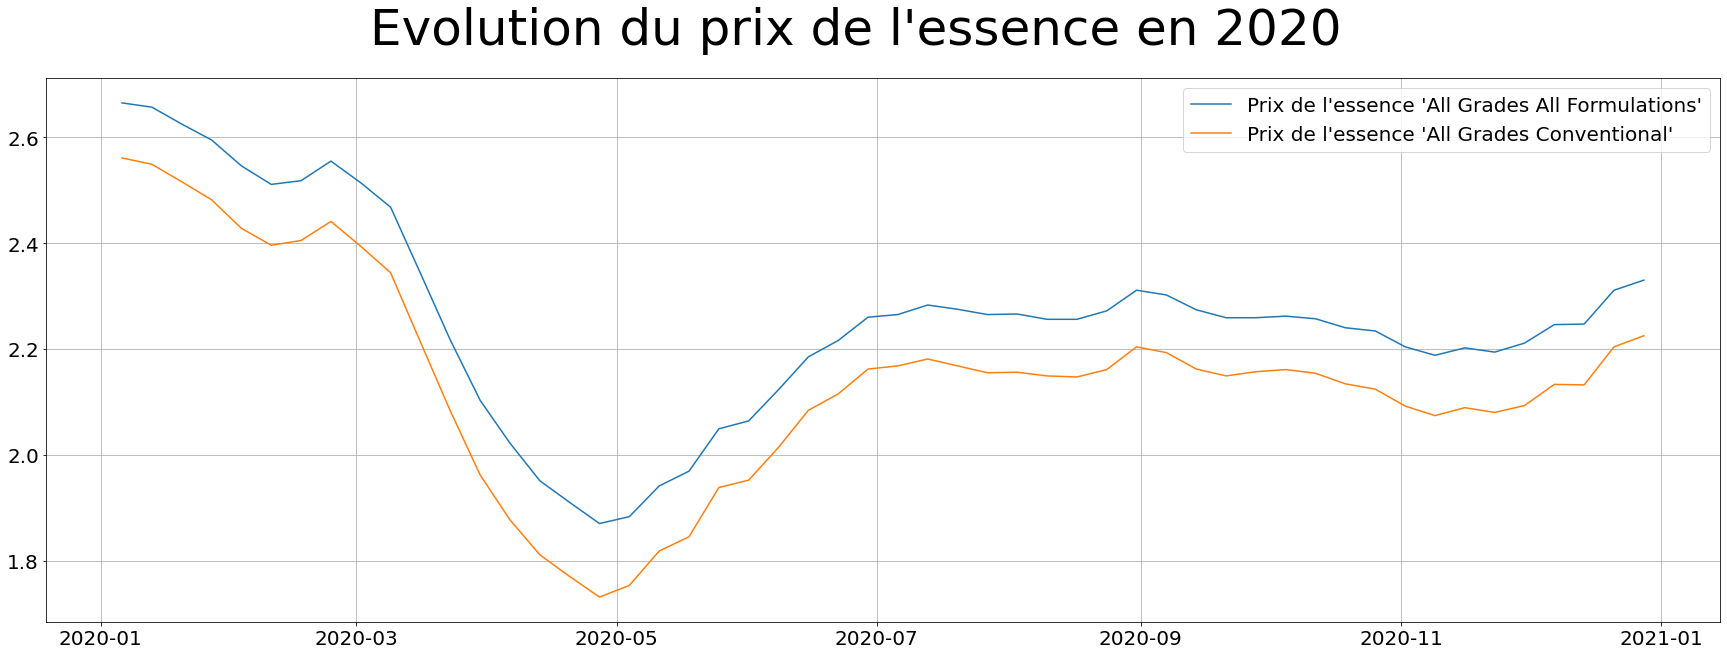

In [34]:
# Plotting to our canvas  

fig = plt.figure(1, figsize=(30, 10))
ax = fig.add_subplot(1, 1, 1)
plt.plot(date_date_galons, prix_data_galons, label="Prix de l'essence 'All Grades All Formulations'")
plt.plot(date_date_galons, prix_data_galons_2, label="Prix de l'essence 'All Grades Conventional'")
ax.tick_params(axis = 'both', labelsize = 15)

ax.tick_params(axis = 'both', labelsize = 20)
ax.grid(which='both')
ax.legend(fontsize=20)

fig.suptitle('Evolution du prix de l\'essence en 2020', fontsize=50)


In [16]:
rdd = sc.textFile(r"./data/covid.csv")
covid_head = rdd.take(1)
covid_no_header = rdd.filter(lambda row: row != covid_head[0])
covid_head

['Country_Region,Population_Size,Tourism,Date_FirstFatality,Date_FirstConfirmedCase,Latitude,Longtitude,Mean_Age,Lockdown_Date,Lockdown_Type,Country_Code']

In [18]:
#covid_no_header.collect()

In [19]:
covid_country = covid_no_header.map(lambda x : x.split(',')) \
                               .map(lambda x : tuple(x[0:2] + x[3:5] + x[8: 10])) \
                               .filter(lambda line : '' not in line)\
                               .map(lambda x : (x[0:2] + tuple(map(lambda x : 
                                                                   datetime.strptime(x, "%Y-%m-%d"),x[2:5])) + x[5:])).sortBy(lambda x: x[-2], ascending=True)

In [37]:

scaler = MinMaxScaler()

date_lock = covid_country.map(lambda x : x[-2]).collect()
name_pays = covid_country.map(lambda x : x[0]).collect()
date_death = covid_country.map(lambda x : x[2]).sortBy(lambda x: x, ascending=True).collect()
date_first_case =  covid_country.map(lambda x : x[3]).sortBy(lambda x: x, ascending=True).collect()

nb_pays_lock = np.array([i for i in range(1,len(name_pays) + 1)]).reshape(-1, 1)
scaler.fit(nb_pays_lock)
nb_pays_lock_norm = scaler.transform(nb_pays_lock)
scaler.fit(np.array(prix_data_galons).reshape(-1, 1))
prix_galons_norm = scaler.transform(np.array(prix_data_galons).reshape(-1, 1))

Text(0.5, 0.98, 'Evolution des comportements des différents pays en 2020')

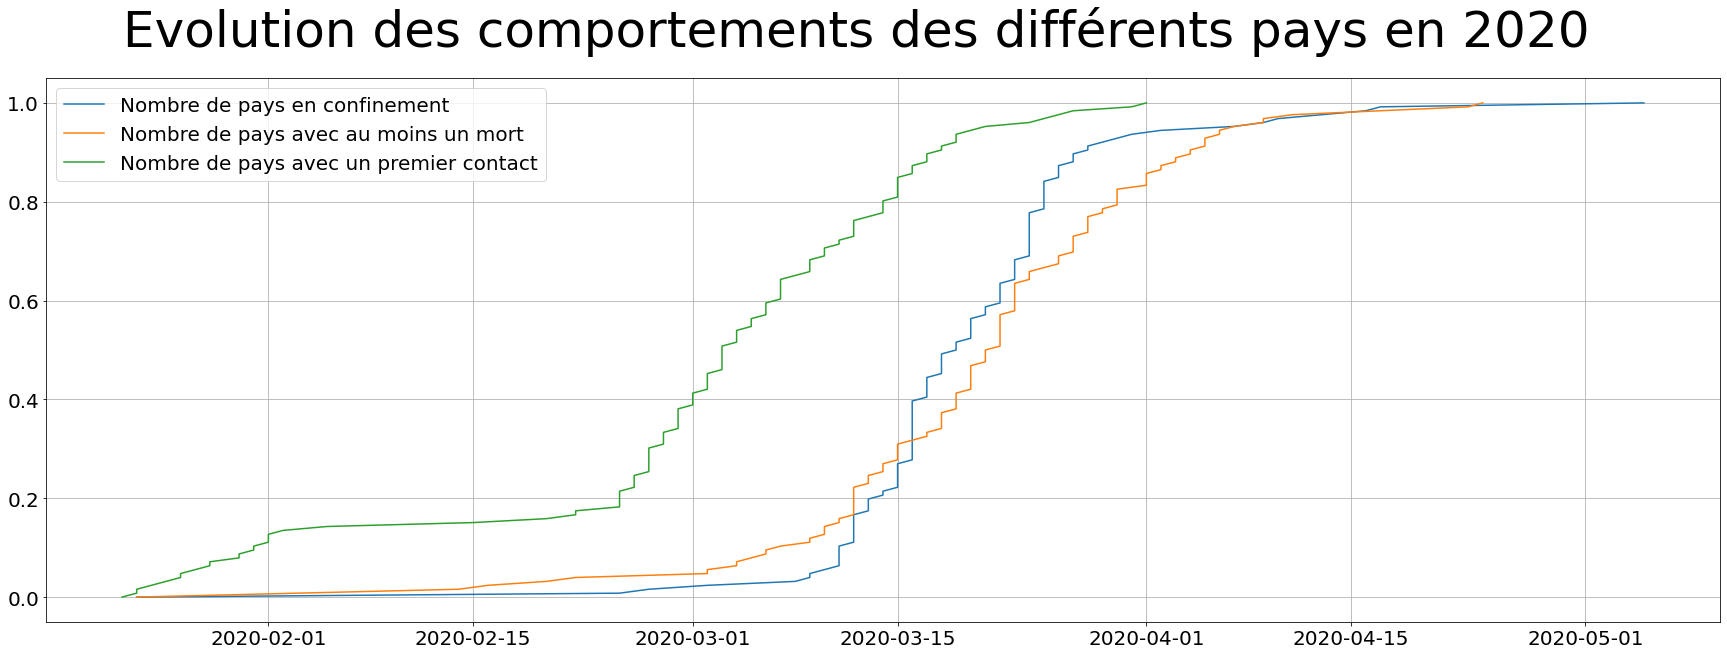

In [38]:
fig = plt.figure(1, figsize=(30, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(date_lock , nb_pays_lock_norm, label="Nombre de pays en confinement")
ax.plot(date_death , nb_pays_lock_norm, label="Nombre de pays avec au moins un mort")
ax.plot(date_first_case , nb_pays_lock_norm, label="Nombre de pays avec un premier contact")

ax.tick_params(axis = 'both', labelsize = 20)
ax.grid(which='both')
ax.legend(fontsize=20)

fig.suptitle('Evolution des comportements des différents pays en 2020', fontsize=50)

Text(0.5, 0.98, "Observation de l'impact du covid sur le prix de l'essence")

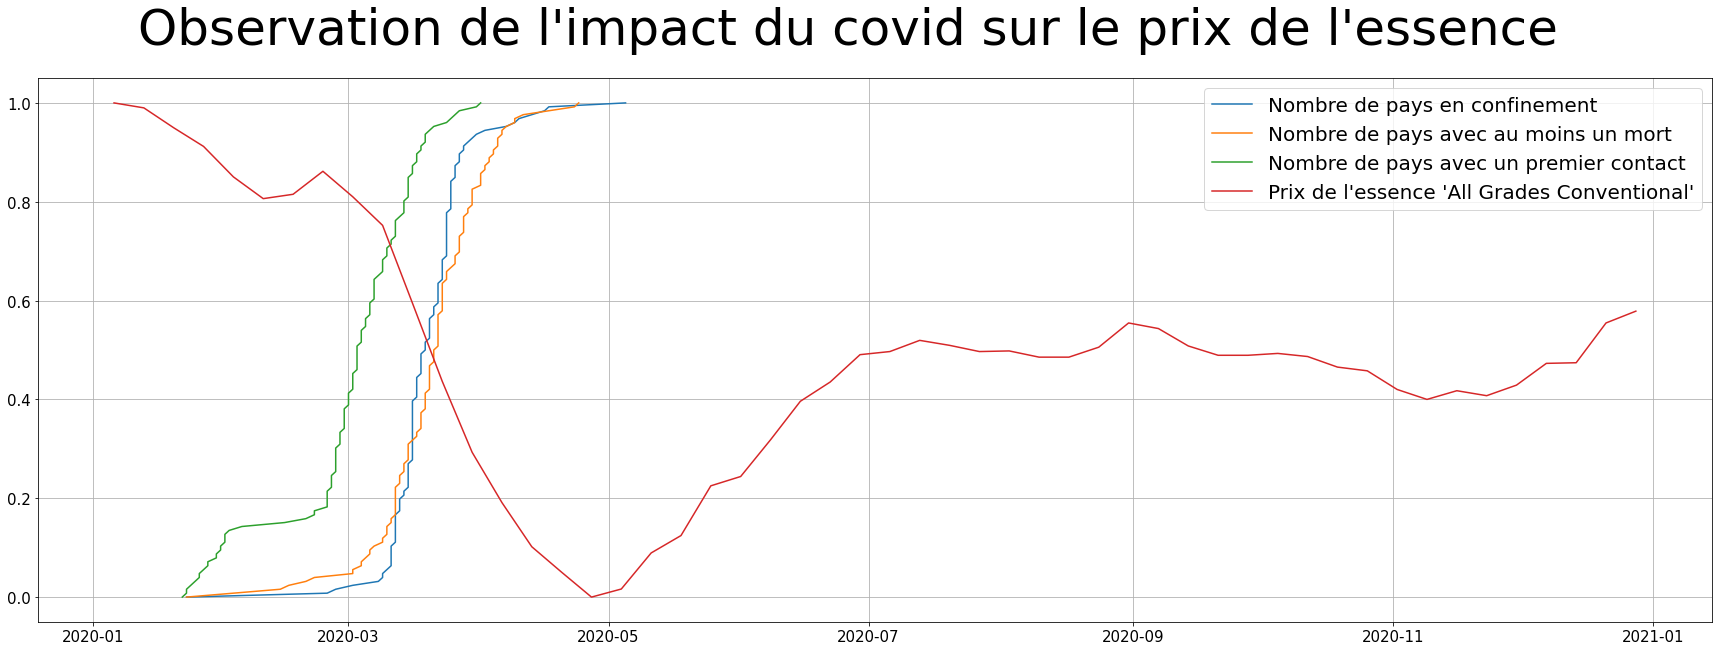

In [44]:
fig = plt.figure(1, figsize=(30, 10))
ax = fig.add_subplot(1, 1, 1)

plt.plot(date_lock , nb_pays_lock_norm, label="Nombre de pays en confinement")
plt.plot(date_death , nb_pays_lock_norm, label="Nombre de pays avec au moins un mort")
plt.plot(date_first_case , nb_pays_lock_norm, label="Nombre de pays avec un premier contact")

plt.plot(date_date_galons, prix_galons_norm, label="Prix de l'essence 'All Grades Conventional'")

ax.legend(fontsize=20)
ax.tick_params(axis = 'both', labelsize = 15)
coord = tuple(zip(date_lock, nb_pays_lock))
ax.grid(which='both')

fig.suptitle("Observation de l\'impact du covid sur le prix de l\'essence", fontsize=50)

In [45]:
covid1 = covid_country.map(lambda x: tuple(list(x) + [(x[4] - x[3]).days])).sortBy(lambda x: x[-1], ascending=False)
reactivity = covid1.map(lambda x : x[-1]).collect()[0:25]

In [46]:
country = covid1.map(lambda x: x[0]).collect()[0:25]
#country

Text(0.5, 0.98, 'Temps de réactivité par pays')

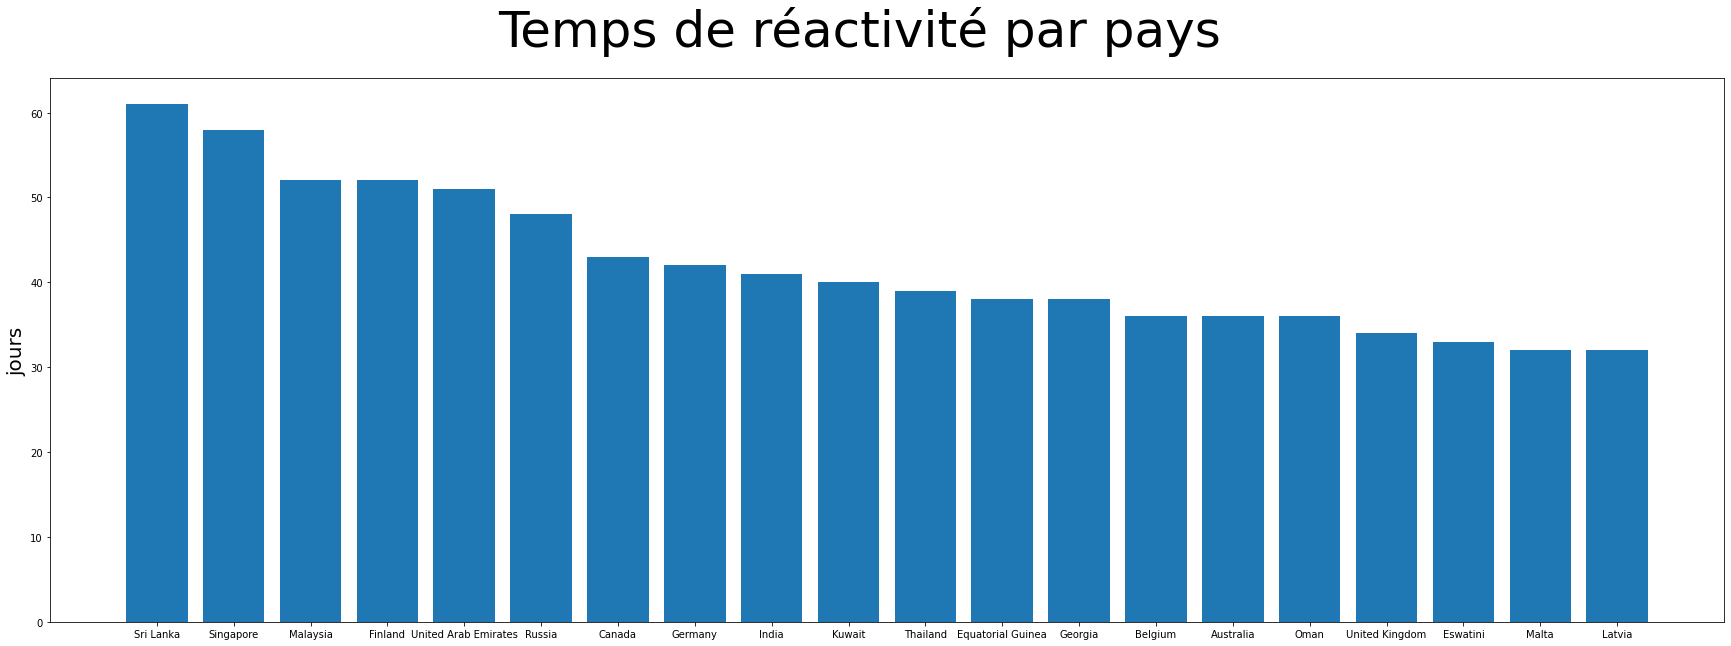

In [70]:
covid1 = covid_country.map(lambda x: tuple(list(x) + [(x[2] - x[3]).days])).sortBy(lambda x: x[-1], ascending=False)
reactivity = covid1.map(lambda x : x[-1]).collect()[0:20]
country = covid1.map(lambda x: x[0]).collect()[0:20]
fig = plt.figure(1, figsize=(30, 10))
ax = fig.add_subplot(1, 1, 1)
plt.bar(country, reactivity)

plt.ylabel("jours", fontsize=20)

fig.suptitle("Temps de réactivité par pays", fontsize=50)

# Dataset sur le vaccin

In [52]:
spark = SparkSession.builder.appName("etienne").getOrCreate()

sc = spark.sparkContext
rdd = sc.textFile(r"./data/country_vaccinations.csv")
vaccin_head = rdd.take(1)
vaccin_no_header = rdd.filter(lambda row: row != vaccin_head[0])
vaccin_head[0].split(",")


['country',
 'iso_code',
 'date',
 'total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'daily_vaccinations_raw',
 'daily_vaccinations',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'people_fully_vaccinated_per_hundred',
 'daily_vaccinations_per_million',
 'vaccines',
 'source_name',
 'source_website']

In [54]:

new_vaccin_rdd = vaccin_no_header.map(lambda line: tuple(line.split(','))) \
                                 .map(lambda line: (line[0], line[2], line[3])) \
                                 .filter(lambda x : '' not in x) \
                                 .map(lambda x: (x[0], datetime.strptime(x[1], "%Y-%m-%d"), float(x[2])))
#new_vaccin_rdd.collect()


In [55]:
rdd = sc.textFile(r"./data/cass.csv")
tweet_vaccin_head = rdd.take(1)
tweet_vacin = rdd.filter(lambda row: row != tweet_vaccin_head[0])
tweet_vaccin_head[0].split("\t")

['id',
 'user_name',
 'user_location',
 'user_description',
 'user_created',
 'user_followers',
 'user_friends',
 'user_favourites',
 'user_verified',
 'date',
 'text',
 'hashtags',
 'source',
 'retweets',
 'favorites',
 'is_retweet']

In [57]:
new_tweet_vaccin = tweet_vacin.map(lambda line: tuple(line.split('\t'))) \
                              .map(lambda x: x[2:3])

#new_tweet_vaccin.collect()

In [59]:
pays = new_tweet_vaccin.map(lambda x: tuple(x[0], 0))

In [62]:
df = pd.read_csv('./data/vaccination_all_tweets.csv')

## Nettoyage : retrait des "\n" dans le dataset

In [63]:
df['text'] = df['text'].map(lambda x: x.replace("\n", ""))
df['source'] = df['source'].map(lambda x: str(x))
df['source'] = df['source'].map(lambda x: x.replace("\n", ""))
df['hashtags'] = df['hashtags'].map(lambda x: str(x))
df['hashtags'] = df['hashtags'].map(lambda x: x.replace("\n", ""))
df['user_description'] = df['user_description'].map(lambda x: str(x))
df['user_description'] = df['user_description'].map(lambda x: x.replace("\n", ""))
df.to_csv('cass.csv', index=False, sep='\t')

In [64]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,nan,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",nan,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
